# Coffee Bean Spectra Analysis

This notebook assumes that 
- the data have been downloaded from http://csr.quadram.ac.uk/wp-content/uploads/FTIRSpectraInstantCoffee.zip
- the ZIP archive has been extracted into a folder .\data

#### Import required libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import re 

import dslab
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Bruno\Anaconda3\envs\DSlab\python.exe
{'numpy': '1.16.4', 'pandas': '0.23.4', 'seaborn': '0.9.0', 'sklearn': '0.21.2', 'matplotlib': '3.1.1'}


#### Set seed for numpy random number generator for reproducable results

In [2]:
np.random.seed(0)

#### Check version of important packages

In [3]:
dict([(m.__name__, m.__version__) for m in [np, pd, sns, sklearn, matplotlib]])

{'numpy': '1.16.4',
 'pandas': '0.23.4',
 'seaborn': '0.9.0',
 'sklearn': '0.21.2',
 'matplotlib': '3.1.1'}

## Load the data and perform an exploratory analysis

#### Load instant coffee spectra data into a pandas data frame to easily manipulate and visualize tabular data

In [4]:
df = pd.read_csv("./data/FTIR_Spectra_instant_coffee.csv")
df.shape

(288, 57)

#### look at first five rows of of csv file. This allows to develop a method to manipulate the data into a structure that enables easy visualization of wavelengths and reflectances for each class (Robusta and Arabica beans) and allows signal operators to be applied.

In [5]:
df.head()

,Sample Number:,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,Group Code:,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
1,Wavenumbers,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,Arabica,...,Robusta,Robusta,Robusta,Robusta,Robusta,Robusta,Robusta,Robusta,Robusta,Robusta
2,810.548,21.22761979,10.36424268,13.11832444,15.66840884,16.63495952,13.16534882,12.60723223,16.10922758,13.56993291,...,11.71916759,9.106253982,8.343802657,9.425892805,10.11760123,8.962248884,10.64082482,10.7494047,10.24020041,10.91880607
3,814.408,21.83750917,10.56955401,13.50708386,15.80386848,17.05526334,13.58740534,13.27727227,16.34067596,13.72290689,...,11.82945802,9.243098876,8.425414627,9.86365095,10.25910167,9.345451483,11.13920059,10.90005154,10.45899096,11.37172994
4,818.268,22.72997487,10.44887452,13.47349516,15.97760653,17.61049509,13.99858385,13.17792276,16.39799406,13.89180767,...,12.01596934,9.305462673,8.281403222,9.854026689,10.16585294,9.281157939,11.07029305,10.76243519,10.43644326,11.27420943


#### Create a data frame comtaining a list of the class of bean corresponding to each spectra sample use the sample as an index for easy merging of data frames indexed by the sample number and find and check the indexes corresponding to samples of Arabica and Robusta bean spectra.

In [6]:
# Show 2nd row (index 1)
coffee = df.iloc[1][1:]
coffee.index = coffee.index.astype(int)
coffee

1     Arabica
2     Arabica
3     Arabica
4     Arabica
5     Arabica
6     Arabica
7     Arabica
8     Arabica
9     Arabica
10    Arabica
11    Arabica
12    Arabica
13    Arabica
14    Arabica
15    Arabica
16    Arabica
17    Arabica
18    Arabica
19    Arabica
20    Arabica
21    Arabica
22    Arabica
23    Arabica
24    Arabica
25    Arabica
26    Arabica
27    Arabica
28    Arabica
29    Arabica
30    Robusta
31    Robusta
32    Robusta
33    Robusta
34    Robusta
35    Robusta
36    Robusta
37    Robusta
38    Robusta
39    Robusta
40    Robusta
41    Robusta
42    Robusta
43    Robusta
44    Robusta
45    Robusta
46    Robusta
47    Robusta
48    Robusta
49    Robusta
50    Robusta
51    Robusta
52    Robusta
53    Robusta
54    Robusta
55    Robusta
56    Robusta
Name: 1, dtype: object

In [7]:
coffee[:29].tail()

25    Arabica
26    Arabica
27    Arabica
28    Arabica
29    Arabica
Name: 1, dtype: object

In [8]:
coffee[29:].head()

30    Robusta
31    Robusta
32    Robusta
33    Robusta
34    Robusta
Name: 1, dtype: object

#### Obtain the names of all columns in the dataframe containing the full csv file for later access

In [9]:
df.columns

Index(['Sample Number:', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56'],
      dtype='object')

#### Create a dataframe only containing frequency and reflectance values for each sample for feature processing 

In [10]:
X = df.drop([0, 1]).apply(pd.to_numeric)
X.head()

,Sample Number:,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
2,810.548,21.227620,10.364243,13.118324,15.668409,16.634960,13.165349,12.607232,16.109228,13.569933,...,11.719168,9.106254,8.343803,9.425893,10.117601,8.962249,10.640825,10.749405,10.240200,10.918806
3,814.408,21.837509,10.569554,13.507084,15.803868,17.055263,13.587405,13.277272,16.340676,13.722907,...,11.829458,9.243099,8.425415,9.863651,10.259102,9.345451,11.139201,10.900052,10.458991,11.371730
4,818.268,22.729975,10.448875,13.473495,15.977607,17.610495,13.998584,13.177923,16.397994,13.891808,...,12.015969,9.305463,8.281403,9.854027,10.165853,9.281158,11.070293,10.762435,10.436443,11.274209
5,822.128,22.517663,10.100696,12.871428,15.569489,17.211594,13.476876,12.570892,16.093075,13.525417,...,11.652528,9.130744,7.897150,9.509302,9.810642,8.781616,10.597854,10.228245,10.067882,10.792971
6,825.988,21.040178,9.620371,12.181919,14.950423,16.217897,12.577613,11.818907,15.660423,12.865660,...,10.864570,8.709047,7.388507,8.851643,9.164671,8.263632,9.987684,9.563644,9.505865,9.997847


#### Create dataframe with the column containing wavelengths being named 'wavelength' for readability and easy access 

In [11]:
df2 = X.rename({'Sample Number:': 'wavelength'}, axis=1)
df2.head()

,wavelength,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
2,810.548,21.227620,10.364243,13.118324,15.668409,16.634960,13.165349,12.607232,16.109228,13.569933,...,11.719168,9.106254,8.343803,9.425893,10.117601,8.962249,10.640825,10.749405,10.240200,10.918806
3,814.408,21.837509,10.569554,13.507084,15.803868,17.055263,13.587405,13.277272,16.340676,13.722907,...,11.829458,9.243099,8.425415,9.863651,10.259102,9.345451,11.139201,10.900052,10.458991,11.371730
4,818.268,22.729975,10.448875,13.473495,15.977607,17.610495,13.998584,13.177923,16.397994,13.891808,...,12.015969,9.305463,8.281403,9.854027,10.165853,9.281158,11.070293,10.762435,10.436443,11.274209
5,822.128,22.517663,10.100696,12.871428,15.569489,17.211594,13.476876,12.570892,16.093075,13.525417,...,11.652528,9.130744,7.897150,9.509302,9.810642,8.781616,10.597854,10.228245,10.067882,10.792971
6,825.988,21.040178,9.620371,12.181919,14.950423,16.217897,12.577613,11.818907,15.660423,12.865660,...,10.864570,8.709047,7.388507,8.851643,9.164671,8.263632,9.987684,9.563644,9.505865,9.997847


#### View column containing wavelengths

In [12]:
df2['wavelength'].head()

2    810.548
3    814.408
4    818.268
5    822.128
6    825.988
Name: wavelength, dtype: float64

## Visualizations showing the differences between the two different types of signals:

#### For each class of bean, for each sample, plot reflectance vs wavelength. When all samples are plotted like this, the two classes are difficult to distinguish

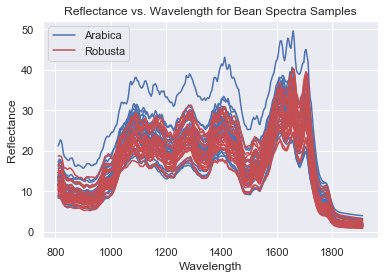

In [13]:
[plt.plot(df2['wavelength'], df2[str(x)], '-b', label='Arabica' if x == 1 else '') for x in range(1,30)]
[plt.plot(df2['wavelength'], df2[str(x)], '-r', label='Robusta' if x == 30 else '') for x in range(30,57)]
plt.title('Reflectance vs. Wavelength for Bean Spectra Samples')
plt.legend(loc='upper left')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance');

#### Create a data frame with one column for wavelength and one for reflectance, and maintain a mapping to sample number by storing the sample number corresponding to each wavelength, reflectance pair in another column. Next, set the index of the new data frame to be the wave length - this allows for easy grouping of reflectance values for each sample. The first 5 rows of the resulting dataframe is printed to view the new structure.

In [14]:
df3 = df2.melt(id_vars='wavelength', 
         var_name='sample', 
         value_name='reflectance')
df3['sample'] = df3['sample'].astype(int)
df3.set_index('wavelength')
print(df3.reflectance.shape)
df3.head()

(16016,)


,wavelength,sample,reflectance
0,810.548,1,21.227620
1,814.408,1,21.837509
2,818.268,1,22.729975
3,822.128,1,22.517663
4,825.988,1,21.040178


#### Create two data frames with a single column and index, one containing the reflectances of the arabica bean spectra and one containing the reflectances of the robusta bean spectra.

In [15]:
mask = df3['sample'] <= 29
df3_Arabica_reflectance = df3[mask].reflectance
print(df3_Arabica_reflectance.shape)
df3_Arabica_reflectance.head()

(8294,)


0    21.227620
1    21.837509
2    22.729975
3    22.517663
4    21.040178
Name: reflectance, dtype: float64

In [16]:
mask = df3['sample'] > 29
df3_Robusta_reflectance = df3[mask].reflectance

print(df3_Robusta_reflectance.shape)
df3_Robusta_reflectance.head()

(7722,)


8294    12.847924
8295    13.198358
8296    13.074410
8297    12.622615
8298    12.008840
Name: reflectance, dtype: float64

#### Now plot the distributions of the reflectances for the two bean spectra. Again the plot shows that there is substantial overlap between the two signals, perhaps feature engineering will help in differentiating them!

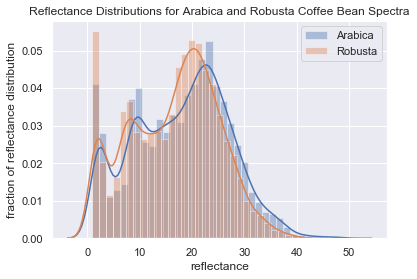

In [17]:
# [plt.plot(df2['wavelength'], df3[str(x)]) for x in range(1,23)]
sns.distplot(df3_Arabica_reflectance, label='Arabica')
sns.distplot(df3_Robusta_reflectance, label='Robusta')
plt.legend(loc='upper right')
plt.ylabel('fraction of reflectance distribution')
plt.title('Reflectance Distributions for Arabica and Robusta Coffee Bean Spectra');

#### Create two data frames, each containing data for a single sample, one containing a sample of robusta spectra and one containing a sample of arabica spectra. For each of the single samples, the reflectances are then plotted against wavelength and a histogram of the reflectances is also plotted. The plots shows an example of the degree of variation between individual samples from each class. 

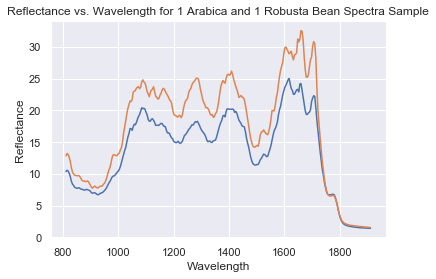

In [18]:
mask = df3['sample'] == 2
sample1_Arabica = df3[mask]
sample1_Arabica.head()
sample1_Arabica_with_index = sample1_Arabica.set_index('wavelength')
sample1_Arabica_with_index.head()
sample1_Arabica_with_index.reflectance.plot()

mask = df3['sample'] == 30
sample1_Robusta = df3[mask]
sample1_Robusta.head()
sample1_Robusta_with_index = sample1_Robusta.set_index('wavelength')
sample1_Robusta_with_index.head()
sample1_Robusta_with_index.reflectance.plot()
plt.title('Reflectance vs. Wavelength for 1 Arabica and 1 Robusta Bean Spectra Sample')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance');

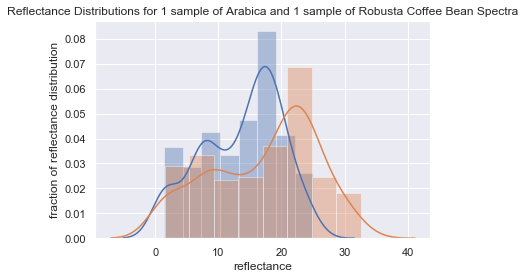

In [19]:
sns.distplot(sample1_Arabica_with_index.reflectance)
sns.distplot(sample1_Robusta_with_index.reflectance)
plt.ylabel('fraction of reflectance distribution')
plt.title('Reflectance Distributions for 1 sample of Arabica and 1 sample of Robusta Coffee Bean Spectra');

## Apply signal processors to extract information about the statistics of the signals:

#### Extract features by applying the 'groupby' function to df3 to create 5 dataframes, each containing either the min, max, mean, variance, or standard deviation of the wavelength and reflectances for each sample. Note that the extracted wavelength values are the same for all samples as a the reflectance has been recorded for each wavelength for every sample. The extracted wavelength values are therefore not useful for classification.

In [20]:
df_min = df3.groupby('sample').min()
df_min = df_min.rename({'wavelength':'wavelength min', 'reflectance':'reflectance min'}, axis=1)
df_min.head()

,wavelength min,reflectance min
sample,,
1,810.548,4.042686
2,810.548,1.418705
3,810.548,2.121559
4,810.548,2.876201
5,810.548,3.146584


In [21]:
df_max = df3.groupby('sample').max()
df_max = df_max.rename({'wavelength':'wavelength max', 'reflectance': 'reflectance max'}, axis=1)
df_max.head()

,wavelength max,reflectance max
sample,,
1,1910.644,49.635114
2,1910.644,25.008890
3,1910.644,31.903342
4,1910.644,35.930368
5,1910.644,40.664246


In [22]:
df_mean = df3.groupby('sample').mean()
df_mean = df_mean.rename({'wavelength':'wavelength mean', 'reflectance': 'reflectance mean'}, axis=1)
df_mean.head()

,wavelength mean,reflectance mean
sample,,
1,1360.595615,28.097496
2,1360.595615,13.635671
3,1360.595615,17.843342
4,1360.595615,20.694775
5,1360.595615,22.771074


In [23]:
df_std = df3.groupby('sample').std() #sample standard deviation 
df_std = df_std.rename({'wavelength':'wavelength std', 'reflectance': 'reflectance std'}, axis=1)
df_std.head()

,wavelength std,reflectance std
sample,,
1,319.241275,11.960682
2,319.241275,6.310395
3,319.241275,7.944634
4,319.241275,9.164480
5,319.241275,9.734869


In [24]:
df_var = df3.groupby('sample').var() #sample variance
df_var = df_var.rename({'wavelength':'wavelength var', 'reflectance': 'reflectance var'}, axis=1)
df_var.head()

,wavelength var,reflectance var
sample,,
1,101914.991846,143.057905
2,101914.991846,39.821082
3,101914.991846,63.117205
4,101914.991846,83.987702
5,101914.991846,94.767680


#### Create a data frame containing reflectance values with rows indexed by sample number and columns named by wavelength so that the reflectance value corresponding to each wavelength can be input as a feature into the classifier.

In [25]:
df4 = df2.set_index('wavelength').T
df4.index.names = ['sample']
df4.index = df4.index.astype(int)
df4.columns = df4.columns.astype(str)
df4.columns.names = ['']
df4.head()

,810.548,814.408,818.268,822.128,825.988,829.8480000000001,833.7080000000001,837.568,841.428,845.288,...,1875.904,1879.764,1883.624,1887.484,1891.344,1895.204,1899.0639999999999,1902.924,1906.7839999999999,1910.644
sample,,,,,,,,,,,,,,,,,,,,,
1,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.299971,4.271924,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686
2,10.364243,10.569554,10.448875,10.100696,9.620371,8.882499,8.415529,8.210217,7.916430,7.806151,...,1.518927,1.505118,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705
3,13.118324,13.507084,13.473495,12.871428,12.181919,11.239480,10.515672,10.468178,10.428742,10.212771,...,2.273844,2.254481,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559
4,15.668409,15.803868,15.977607,15.569489,14.950423,14.029599,13.396739,13.092360,12.784991,12.829988,...,3.075677,3.046015,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201
5,16.634960,17.055263,17.610495,17.211594,16.217897,15.287751,14.424133,13.928921,13.551499,13.288979,...,3.379194,3.342549,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584


#### Create a data frame containing all the extracted features

In [26]:
df_features = pd.concat([df_min.iloc[:,1:2], df_max.iloc[:,1:2], df_mean.iloc[:,1:2], df_std.iloc[:,1:2], df_var.iloc[:,1:2], df4], sort=True, axis=1)
df_features.head()

,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,825.988,...,1875.904,1879.764,1883.624,1887.484,1891.344,1895.204,1899.0639999999999,1902.924,1906.7839999999999,1910.644
sample,,,,,,,,,,,,,,,,,,,,,
1,4.042686,49.635114,28.097496,11.960682,143.057905,21.227620,21.837509,22.729975,22.517663,21.040178,...,4.299971,4.271924,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686
2,1.418705,25.008890,13.635671,6.310395,39.821082,10.364243,10.569554,10.448875,10.100696,9.620371,...,1.518927,1.505118,1.493133,1.475563,1.464682,1.456444,1.442087,1.433698,1.425288,1.418705
3,2.121559,31.903342,17.843342,7.944634,63.117205,13.118324,13.507084,13.473495,12.871428,12.181919,...,2.273844,2.254481,2.236715,2.214229,2.196218,2.181646,2.164602,2.146423,2.133255,2.121559
4,2.876201,35.930368,20.694775,9.164480,83.987702,15.668409,15.803868,15.977607,15.569489,14.950423,...,3.075677,3.046015,3.020125,2.987411,2.963816,2.954810,2.942520,2.909018,2.880989,2.876201
5,3.146584,40.664246,22.771074,9.734869,94.767680,16.634960,17.055263,17.610495,17.211594,16.217897,...,3.379194,3.342549,3.310964,3.281866,3.263161,3.241584,3.213549,3.183820,3.157357,3.146584


### Fit logistic regression classiers using the L1 penalty:

#### Prior to fitting logistic regression classifiers, the data must be further preprocessed. 
#### First, a dataframe is created with normalized features by subtracting the mean and then dividing by the standard deviation - it is important to scale the logistic regression coefficients to make them comparable when using the L1 penalty (L1 regularization/LASSO regression) so that large numbers are penalized equivelantly for all features. Scaling of features or logistic regression coefficients is also neccessary to be able to compare logistic regression coefficients in order to rank feature importance. Scaling to ensure values are small also ensures coefficients are small which can reduce compute time. The bean associated with each sample is also added for indexing when evaluating feature importance.

In [27]:
scaled_df_features = pd.concat([pd.DataFrame(scale(df_features), columns=df_features.columns, index=df_features.index)], sort=True, axis=1)
scaled_df_features['coffee'] = coffee
scaled_df_features.head()

,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,825.988,...,1879.764,1883.624,1887.484,1891.344,1895.204,1899.0639999999999,1902.924,1906.7839999999999,1910.644,coffee
sample,,,,,,,,,,,,,,,,,,,,,
1,3.449506,3.394433,3.591472,3.171943,3.729741,3.390533,3.443308,3.609417,3.656351,3.553134,...,3.410589,3.430331,3.451302,3.434118,3.419845,3.431564,3.442521,3.445881,3.449506,Arabica
2,-0.712877,-1.607588,-1.205917,-1.595291,-1.446059,-0.837961,-0.851762,-0.863051,-0.830613,-0.781744,...,-0.752743,-0.744086,-0.742953,-0.735856,-0.725764,-0.726498,-0.722159,-0.717515,-0.712877,Arabica
3,0.402050,-0.207203,0.189884,-0.216458,-0.278103,0.234046,0.267953,0.238440,0.170611,0.190601,...,0.374856,0.381358,0.386117,0.392272,0.399097,0.401545,0.400314,0.404666,0.402050,Arabica
4,1.599128,0.610757,1.135784,0.812745,0.768244,1.226649,1.143431,1.150374,1.145576,1.241506,...,1.565911,1.567082,1.567945,1.576010,1.598353,1.616090,1.601324,1.589880,1.599128,Arabica
5,2.028032,1.572291,1.824550,1.293991,1.308701,1.602872,1.620433,1.745031,1.738963,1.722630,...,2.012118,2.007280,2.018028,2.037641,2.043168,2.039240,2.034110,2.027945,2.028032,Arabica


#### Reset the index of the scaled data frame. Create an numpy array with rows containing samples and columns containing normalized features that will be input into the classifier. Create a list containing the bean type associated with each sample, to be used as labels for each sample. The numpy arrays containing the data are then randomly shuffled whilst maintaining sample feature and label pairs. This is done to ensure each fold of a cross validation has an approximate balance in the number of samples from each bean spectra.

In [28]:
scaled_df_features = scaled_df_features.reset_index()
X = np.array(scaled_df_features.filter(regex='(ref|\.)'))
y = list(coffee)

X, y = shuffle(X, y, random_state=20)
y = list(y)

print(X[:5])
print(y[:5])

[[ 2.02803198  1.57229133  1.82455    ...  2.03411     2.02794468
   2.02803198]
 [ 2.30849075  1.34213767  1.81551801 ...  2.30034437  2.30288689
   2.30849075]
 [-0.29727194  0.38024545 -0.0077395  ... -0.29929345 -0.29669234
  -0.29727194]
 [-0.94533113 -0.47285831 -0.90129901 ... -0.94796625 -0.9484929
  -0.94533113]
 [-1.5186272  -1.67955323 -1.69420606 ... -1.5222795  -1.52132416
  -1.5186272 ]]
['Arabica', 'Arabica', 'Robusta', 'Robusta', 'Robusta']


#### Fitting Logistic Regression Classifiers and making predictions: 

#### Splitting the data into test and train sets: The data is split into 10 splittings or folds, with each containing the features and labels of 5 or 6 samples. For each split in the data, the 1/10 of the data is assigned to be test data, which is used to test the prediction performance of a model, and the remaining data in the split is assigned to be training and validation data - used to train a model. Splitting the data in this way allows predictions to be made for every sample in the original dataset by models that consider such data to be unseen - meaning that the model has not been tuned with the samples being predicted. Note that it is essential for a model to only make predictions on unseen data if a model is to be developed to predict new samples. 

#### Training models with cross-validation: for each train-test split of the data, 10 logistic regression (validation) models are fitted on a random selection of approximately 9/10ths of the training data and evaluated on the remaining 1/10th of the training data in that split. On the the first split, 10 different values for the L1 penalty coefficient are trialled and the one which provides the best performance is chosen to be used for all 10 of these (validation) models. Of the 10 (validation) models, the best performing one is chosen and is stored. The model selected with cross-validation is then used to predict the labels of the test set for the fold, and the predictions are stored, and the accuracy of that model on it's corresponding test set is calculated and printed.

In [29]:
n_splits = 10

kf = KFold(n_splits=n_splits, shuffle=False, random_state=0)
clfs = []
y_preds = []

n_fold = 1

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    n_l1_Coeff = 10
    cv_n_splits = 10
    
    cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=True, random_state=0)
    
    clf = LogisticRegressionCV(penalty='l1', solver='liblinear', random_state=0, Cs=n_l1_Coeff, cv=cv).fit(X_train, y_train)

    clfs.append(clf)
        
    y_pred = clfs[n_fold-1].predict(X_test)
    
    y_preds.append(y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    
    print('fold ', n_fold, ' accuracy = ', acc)

    n_fold += 1

fold  1  accuracy =  1.0
fold  2  accuracy =  1.0
fold  3  accuracy =  1.0
fold  4  accuracy =  1.0
fold  5  accuracy =  1.0
fold  6  accuracy =  1.0
fold  7  accuracy =  1.0
fold  8  accuracy =  1.0
fold  9  accuracy =  1.0
fold  10  accuracy =  1.0


#### To see how features are discarded by the L1 regularization, the logistic regression coefficients from the model trained in the last fold are printed below:

In [30]:
print(clfs[n_fold-2].coef_[0])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.73373196  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

### Inspect the most important features:

#### The feature importance is calculated by averaging the logistic regression coefficients of all the models, and then sorting them. The relative importances of the 10 most important features are then plotted. None of the features extracted using signal operators such as min, max, mean etc. are included in the 10 most important features.

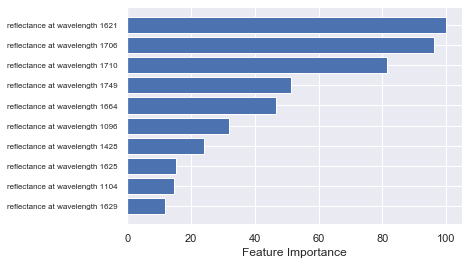

In [31]:
avg_feature_importance = 0

for s in range(n_splits):
    feature_importance = abs(clfs[s].coef_[0])
    avg_feature_importance += feature_importance
    
avg_feature_importance /= n_splits

# ind = np.argpartition(avg_feature_importance, -10)[-10:]
# ind = ind[np.argsort(avg_feature_importance[ind])]
# print(ind)
# print(avg_feature_importance[ind])
# print(avg_feature_importance[ind]/ avg_feature_importance.max())
# print(np.array(scaled_df_features.filter(regex='(ref|\.)').columns)[ind])

avg_feature_importance = 100.0 * (avg_feature_importance / avg_feature_importance.max())
sorted_idx = np.argsort(avg_feature_importance)

n_most_important_features = 10

pos = np.arange(n_most_important_features) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
avg_feature_importance = avg_feature_importance[sorted_idx]

featax.barh(pos, avg_feature_importance[-n_most_important_features:], align='center')
featax.set_yticks(pos)
sorted_col_names = np.array(scaled_df_features.filter(regex='(ref|\.)').columns)[sorted_idx]

most_important_feature_names = sorted_col_names[-n_most_important_features:]
most_important_feature_labels = ["reflectance at wavelength {0:.4g}".format(float(s)) if re.search('(\.)', s) else s for s in most_important_feature_names]
featax.set_yticklabels(most_important_feature_labels, fontsize=8)
featax.set_xlabel('Feature Importance')

plt.show()

#### The importance of the features extracted using signal operators such as min, max, mean etc. is also plotted to see the importance of these features relative to the 10 most important features. The plot shows that these extracted features were not useful relative to the reflectances at the most important specific wavelengths.

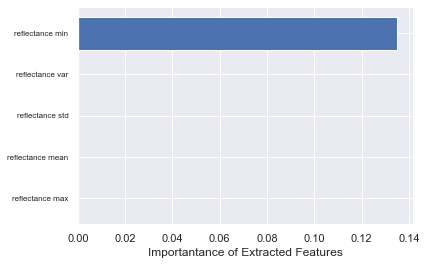

In [32]:
pos = np.arange(5) + .5
sorted_extracted_feature_names_idx = np.array([idx for idx, s in enumerate(sorted_col_names) if re.search('(ref)', s)])
sorted_extracted_feature_names = sorted_col_names[sorted_extracted_feature_names_idx]

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, avg_feature_importance[sorted_extracted_feature_names_idx], align='center')
featax.set_yticks(pos)

featax.set_yticklabels(sorted_extracted_feature_names, fontsize=8)
featax.set_xlabel('Importantance of Extracted Features')

plt.show()

### Visualize the most important features:
#### Create and check masks for each class of bean spectra, for plotting the two distributions of each of the most important features.

In [33]:
scaled_df_features['sample'] = scaled_df_features['sample'].apply(pd.to_numeric)
R_mask = scaled_df_features['coffee'] == 'Robusta'
A_mask = scaled_df_features['coffee'] == 'Arabica'
R_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: coffee, dtype: bool

In [34]:
A_mask.head()

0    True
1    True
2    True
3    True
4    True
Name: coffee, dtype: bool

In [35]:
scaled_df_features[A_mask].head()

,sample,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,...,1879.764,1883.624,1887.484,1891.344,1895.204,1899.0639999999999,1902.924,1906.7839999999999,1910.644,coffee
0,1,3.449506,3.394433,3.591472,3.171943,3.729741,3.390533,3.443308,3.609417,3.656351,...,3.410589,3.430331,3.451302,3.434118,3.419845,3.431564,3.442521,3.445881,3.449506,Arabica
1,2,-0.712877,-1.607588,-1.205917,-1.595291,-1.446059,-0.837961,-0.851762,-0.863051,-0.830613,...,-0.752743,-0.744086,-0.742953,-0.735856,-0.725764,-0.726498,-0.722159,-0.717515,-0.712877,Arabica
2,3,0.402050,-0.207203,0.189884,-0.216458,-0.278103,0.234046,0.267953,0.238440,0.170611,...,0.374856,0.381358,0.386117,0.392272,0.399097,0.401545,0.400314,0.404666,0.402050,Arabica
3,4,1.599128,0.610757,1.135784,0.812745,0.768244,1.226649,1.143431,1.150374,1.145576,...,1.565911,1.567082,1.567945,1.576010,1.598353,1.616090,1.601324,1.589880,1.599128,Arabica
4,5,2.028032,1.572291,1.824550,1.293991,1.308701,1.602872,1.620433,1.745031,1.738963,...,2.012118,2.007280,2.018028,2.037641,2.043168,2.039240,2.034110,2.027945,2.028032,Arabica


#### The distributions of each of the 10 most important features for each class of bean spectra are then plotted. The plots show that the most of these have less overlap then the complete distributions. Note, that although some of these distributions overlap the relative importance of the features can be (and has been) proven to be useful by only using the most important features to train and evaluate the logistic regression models - when this was done, little reduction in accuracy was observed.

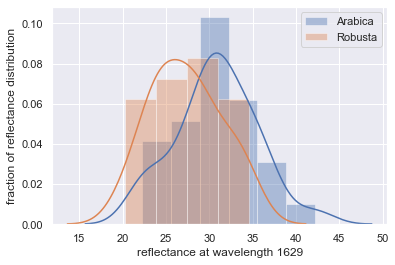

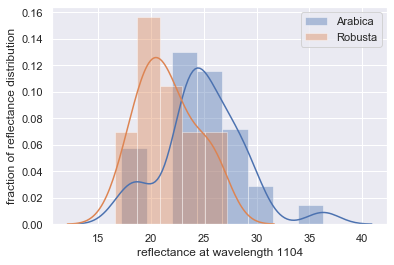

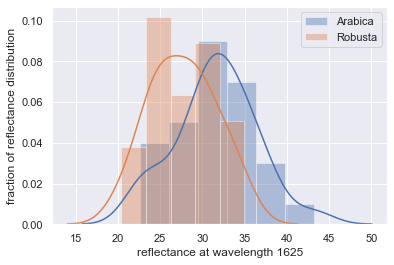

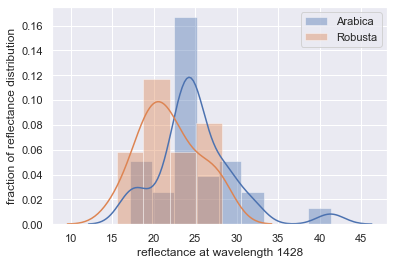

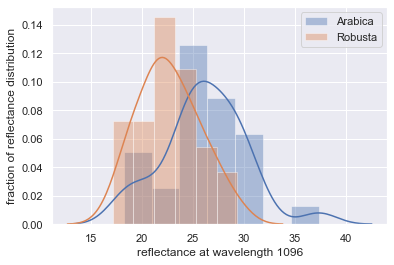

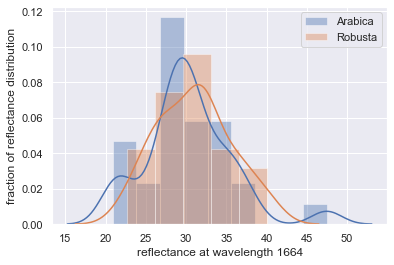

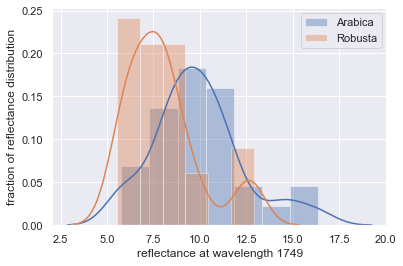

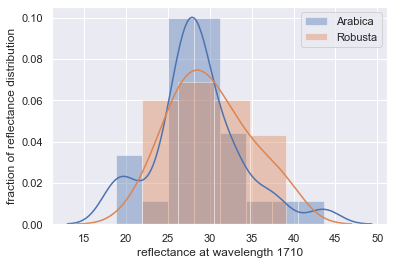

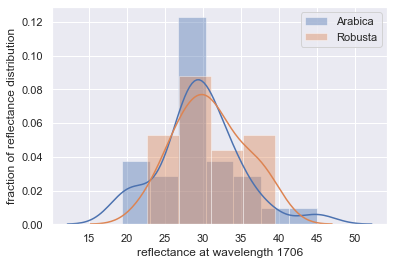

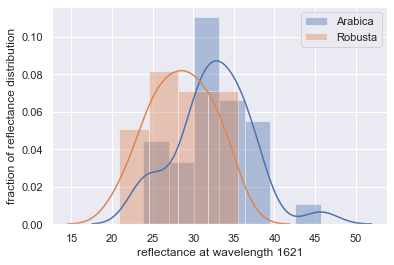

In [36]:
for idx, col in enumerate(most_important_feature_names):
    plt.figure()
    sns.distplot(df_features.reset_index()[A_mask][col], label='Arabica')
    sns.distplot(df_features.reset_index()[R_mask][col], label='Robusta')
    plt.ylabel('fraction of reflectance distribution')
    plt.legend(loc='upper right')
    plt.xlabel(most_important_feature_labels[idx]);

### Evaluate the performance of the classifiers:
#### The accuracy of the combined set of classifiers for predicting the all test sets (so every sample) is calculated by combining all of the predictions and comparing them against the given labels in the original dataset. Note that accuracy is measured as the sum of true positives over the number of data points (samples).

In [37]:
y = np.array(y)
y_preds = np.concatenate(y_preds)

total_acc = accuracy_score(y, y_preds)
print('accuracy = ', total_acc)

accuracy =  1.0


#### Evaluate the confusion of the classifiers by calculating and plotting the confusion matrix for the predictions:
#### The confusion matrix shows that the classifiers are very accurate. However, depending on the seed used, one sample may be misclassified.

In [38]:
cm = confusion_matrix(y, y_preds)
print(cm)

[[29  0]
 [ 0 27]]


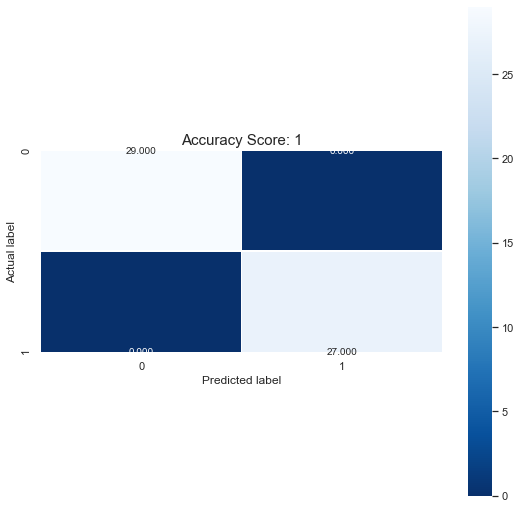

In [39]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4g}'.format(total_acc)
plt.title(all_sample_title, size = 15);

## Design a signal operator and improve your classier:

### Apply signal operator, which transforms the original reflectances to new signals:

#### The signal operator employed here will be a simple derivative of the signal contained within each sample. In this case, that means taking the derivative of the wavelength with respect to the reflectance. This is done using the numpy gradient function.

In [40]:
df2_dot = df2
for x in range(1, df2.shape[1]):
    df2_dot[str(x)] = np.gradient(df2[str(x)], df2['wavelength'])
df2_dot.head()

,wavelength,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
2,810.548,0.158002,0.053189,0.100715,0.035093,0.108887,0.109341,0.173586,0.059961,0.039631,...,0.028573,0.035452,0.021143,0.113409,0.036658,0.099275,0.129113,0.039028,0.056681,0.117338
3,814.408,0.194606,0.010963,0.046007,0.040052,0.126365,0.107932,0.073924,0.037405,0.041694,...,0.038446,0.025804,-0.008083,0.055458,0.006250,0.041309,0.055631,0.001688,0.025420,0.046037
4,818.268,0.088103,-0.060733,-0.082339,-0.030360,0.020250,-0.014317,-0.091500,-0.032073,-0.025582,...,-0.022918,-0.014554,-0.068428,-0.045900,-0.058091,-0.073036,-0.070123,-0.087022,-0.050662,-0.074969
5,822.128,-0.218886,-0.107319,-0.167303,-0.133055,-0.180388,-0.184064,-0.176038,-0.095540,-0.132921,...,-0.149145,-0.077256,-0.115660,-0.129842,-0.129687,-0.131804,-0.140234,-0.155284,-0.120541,-0.165332
6,825.988,-0.422456,-0.157798,-0.211392,-0.199468,-0.249202,-0.192608,-0.199753,-0.167229,-0.210091,...,-0.172745,-0.131532,-0.134835,-0.173780,-0.167365,-0.139117,-0.167736,-0.158471,-0.151232,-0.203959


### Use the output signal to extract the same features as above:

#### Features are then extracted from the new signal containing the derivatives of the original signal as before.

In [41]:
df3_dot = df2_dot.melt(id_vars='wavelength', 
         var_name='sample', 
         value_name='reflectance')
df3_dot['sample'] = df3_dot['sample'].astype(int)
df3_dot.head()

,wavelength,sample,reflectance
0,810.548,1,0.158002
1,814.408,1,0.194606
2,818.268,1,0.088103
3,822.128,1,-0.218886
4,825.988,1,-0.422456


In [42]:
df_dot_min = df3_dot.groupby('sample').min()
df_dot_min = df_dot_min.rename({'wavelength':'wavelength min deriv', 'reflectance': 'min reflectance deriv'}, axis=1)
df_dot_min['coffee'] = coffee
df_dot_min.head()

,wavelength min deriv,min reflectance deriv,coffee
sample,,,
1,810.548,-1.148602,Arabica
2,810.548,-0.493663,Arabica
3,810.548,-0.602742,Arabica
4,810.548,-0.837755,Arabica
5,810.548,-0.788714,Arabica


In [43]:
df_dot_max = df3_dot.groupby('sample').max()
df_dot_max = df_dot_max.rename({'wavelength':'wavelength max deriv', 'reflectance': 'max reflectance deriv'}, axis=1)
df_dot_max['coffee'] = coffee
df_dot_max.head()

,wavelength max deriv,max reflectance deriv,coffee
sample,,,
1,1910.644,0.560822,Arabica
2,1910.644,0.254044,Arabica
3,1910.644,0.371815,Arabica
4,1910.644,0.403237,Arabica
5,1910.644,0.385598,Arabica


In [44]:
df_dot_mean = df3_dot.groupby('sample').mean()
df_dot_mean = df_dot_mean.rename({'wavelength':'wavelength mean deriv', 'reflectance': 'mean reflectance deriv'}, axis=1)
df_dot_mean['coffee'] = coffee
df_dot_mean.head()

,wavelength mean deriv,mean reflectance deriv,coffee
sample,,,
1,1360.595615,-0.015295,Arabica
2,1360.595615,-0.008013,Arabica
3,1360.595615,-0.009790,Arabica
4,1360.595615,-0.011528,Arabica
5,1360.595615,-0.012032,Arabica


In [45]:
df_dot_std = df3_dot.groupby('sample').std() #standard deviation 
df_dot_std = df_dot_std.rename({'wavelength':'wavelength std deriv', 'reflectance': 'std reflectance deriv'}, axis=1)
df_dot_std['coffee'] = coffee
df_dot_std.head()

,wavelength std deriv,std reflectance deriv,coffee
sample,,,
1,319.241275,0.248749,Arabica
2,319.241275,0.119589,Arabica
3,319.241275,0.150539,Arabica
4,319.241275,0.186366,Arabica
5,319.241275,0.181846,Arabica


In [46]:
df_dot_var = df3_dot.groupby('sample').var() #variance
df_dot_var = df_dot_var.rename({'wavelength':'wavelength std deriv', 'reflectance': 'var reflectance deriv'}, axis=1)
df_dot_var['coffee'] = coffee
df_dot_var.head()

,wavelength std deriv,var reflectance deriv,coffee
sample,,,
1,101914.991846,0.061876,Arabica
2,101914.991846,0.014301,Arabica
3,101914.991846,0.022662,Arabica
4,101914.991846,0.034732,Arabica
5,101914.991846,0.033068,Arabica


#### The derivative signal is then also prepared for use as additional features:

In [47]:
df4_dot = df2_dot.set_index('wavelength').T
df4_dot.index.names = ['sample']
df4_dot.index = df4_dot.index.astype(int)
df4_dot.columns = 'derivative of ' + df4_dot.columns.astype(str)
df4_dot.columns.names = ['']
df4_dot.head()

,derivative of 810.548,derivative of 814.408,derivative of 818.268,derivative of 822.128,derivative of 825.988,derivative of 829.8480000000001,derivative of 833.7080000000001,derivative of 837.568,derivative of 841.428,derivative of 845.288,...,derivative of 1875.904,derivative of 1879.764,derivative of 1883.624,derivative of 1887.484,derivative of 1891.344,derivative of 1895.204,derivative of 1899.0639999999999,derivative of 1902.924,derivative of 1906.7839999999999,derivative of 1910.644
sample,,,,,,,,,,,,,,,,,,,,,
1,0.158002,0.194606,0.088103,-0.218886,-0.422456,-0.326709,-0.117686,-0.061392,-0.079264,-0.052815,...,-0.011050,-0.006321,-0.006784,-0.010682,-0.011712,-0.008209,-0.006610,-0.006920,-0.004588,-0.002390
2,0.053189,0.010963,-0.060733,-0.107319,-0.157798,-0.156068,-0.087083,-0.064650,-0.052340,-0.021981,...,-0.003368,-0.003341,-0.003828,-0.003685,-0.002477,-0.002927,-0.002946,-0.002176,-0.001942,-0.001706
3,0.100715,0.046007,-0.082339,-0.167303,-0.211392,-0.215835,-0.099909,-0.011260,-0.033084,-0.047981,...,-0.005092,-0.004810,-0.005214,-0.005246,-0.004221,-0.004095,-0.004563,-0.004060,-0.003221,-0.003030
4,0.035093,0.040052,-0.030360,-0.133055,-0.199468,-0.201254,-0.121404,-0.079242,-0.033986,0.010450,...,-0.007098,-0.007196,-0.007591,-0.007294,-0.004223,-0.002758,-0.005932,-0.007970,-0.004251,-0.001240
5,0.108887,0.126365,0.020250,-0.180388,-0.249202,-0.232353,-0.176014,-0.113035,-0.082894,-0.033985,...,-0.009233,-0.008838,-0.007860,-0.006192,-0.005218,-0.006426,-0.007482,-0.007279,-0.004823,-0.002791


#### All features are then combined for use in logistic regression classifiers:

In [48]:
df_features_inc_dot = pd.concat([df_features, df_dot_min.iloc[:,1:2], df_dot_max.iloc[:,1:2], df_dot_mean.iloc[:,1:2], df_dot_std.iloc[:,1:2], df_dot_var.iloc[:,1:2], df4_dot], sort=False, axis=1)
df_features_inc_dot.head()

,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,825.988,...,derivative of 1875.904,derivative of 1879.764,derivative of 1883.624,derivative of 1887.484,derivative of 1891.344,derivative of 1895.204,derivative of 1899.0639999999999,derivative of 1902.924,derivative of 1906.7839999999999,derivative of 1910.644
sample,,,,,,,,,,,,,,,,,,,,,
1,4.042686,49.635114,28.097496,11.960682,143.057905,21.227620,21.837509,22.729975,22.517663,21.040178,...,-0.011050,-0.006321,-0.006784,-0.010682,-0.011712,-0.008209,-0.006610,-0.006920,-0.004588,-0.002390
2,1.418705,25.008890,13.635671,6.310395,39.821082,10.364243,10.569554,10.448875,10.100696,9.620371,...,-0.003368,-0.003341,-0.003828,-0.003685,-0.002477,-0.002927,-0.002946,-0.002176,-0.001942,-0.001706
3,2.121559,31.903342,17.843342,7.944634,63.117205,13.118324,13.507084,13.473495,12.871428,12.181919,...,-0.005092,-0.004810,-0.005214,-0.005246,-0.004221,-0.004095,-0.004563,-0.004060,-0.003221,-0.003030
4,2.876201,35.930368,20.694775,9.164480,83.987702,15.668409,15.803868,15.977607,15.569489,14.950423,...,-0.007098,-0.007196,-0.007591,-0.007294,-0.004223,-0.002758,-0.005932,-0.007970,-0.004251,-0.001240
5,3.146584,40.664246,22.771074,9.734869,94.767680,16.634960,17.055263,17.610495,17.211594,16.217897,...,-0.009233,-0.008838,-0.007860,-0.006192,-0.005218,-0.006426,-0.007482,-0.007279,-0.004823,-0.002791


### Fit logistic regression classiers using the L1 penalty:

#### Prior to fitting logistic regression classifiers, the data is further preprocessed as originally

In [49]:
scaled_df_features_inc_dot = pd.concat([pd.DataFrame(scale(df_features_inc_dot), columns=df_features_inc_dot.columns, index=df_features_inc_dot.index)], sort=True, axis=1)
scaled_df_features_inc_dot['coffee'] = coffee
scaled_df_features_inc_dot.head()

,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,825.988,...,derivative of 1879.764,derivative of 1883.624,derivative of 1887.484,derivative of 1891.344,derivative of 1895.204,derivative of 1899.0639999999999,derivative of 1902.924,derivative of 1906.7839999999999,derivative of 1910.644,coffee
sample,,,,,,,,,,,,,,,,,,,,,
1,3.449506,3.394433,3.591472,3.171943,3.729741,3.390533,3.443308,3.609417,3.656351,3.553134,...,-0.742124,-0.630284,-2.564954,-3.726674,-2.436647,-1.563633,-2.033442,-1.780443,0.191339,Arabica
2,-0.712877,-1.607588,-1.205917,-1.595291,-1.446059,-0.837961,-0.851762,-0.863051,-0.830613,-0.781744,...,1.365021,1.036347,0.936884,1.273200,0.997367,0.773516,1.073424,1.442557,0.996807,Arabica
3,0.402050,-0.207203,0.189884,-0.216458,-0.278103,0.234046,0.267953,0.238440,0.170611,0.190601,...,0.326550,0.255008,0.155952,0.329032,0.237594,-0.257516,-0.160594,-0.115129,-0.562177,Arabica
4,1.599128,0.610757,1.135784,0.812745,0.768244,1.226649,1.143431,1.150374,1.145576,1.241506,...,-1.361166,-1.085451,-0.869149,0.327794,1.106753,-1.131038,-2.721129,-1.369803,1.544421,Arabica
5,2.028032,1.572291,1.824550,1.293991,1.308701,1.602872,1.620433,1.745031,1.738963,1.722630,...,-2.522601,-1.237232,-0.317719,-0.210887,-1.277793,-2.120392,-2.268209,-2.067152,-0.280662,Arabica


In [50]:
scaled_df_features_inc_dot = scaled_df_features_inc_dot.reset_index()
X = np.array(scaled_df_features_inc_dot.filter(regex='(ref|\.)'))
y = list(coffee)

X, y = shuffle(X, y, random_state=0)
y = list(y)

print(X[:5])
print(y[:5])

[[-0.46879294 -0.58183265 -0.69628041 ...  0.57726883  1.00020388
   0.35304206]
 [-0.14593475  1.02639169  0.70579408 ...  0.01940127  0.22539148
   0.60021937]
 [-0.78959205 -0.07835986 -0.50886595 ...  0.43768524  0.53004896
   0.0258782 ]
 [-1.26567254 -1.72786665 -1.69148208 ...  0.75088495  1.59279756
   1.64068069]
 [ 0.85052889 -0.44610217  0.22286238 ...  0.37226281  1.43074613
   0.74896146]]
['Robusta', 'Robusta', 'Robusta', 'Arabica', 'Arabica']


#### Logistic regression classifiers are fitted and used to make predictions using the same method as that applied to the unmodified reflectance data with extracted features: 

In [51]:
n_splits = 10

kf = KFold(n_splits=n_splits, shuffle=False, random_state=0)
clfs = []
y_preds = []

n_fold = 1

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    n_l1_Coeff = 10
    cv_n_splits = 10
    
    cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=True, random_state=0)
    
    clf = LogisticRegressionCV(penalty='l1', random_state=1, solver='liblinear', Cs=n_l1_Coeff, cv=cv, max_iter=10000).fit(X_train, y_train)
    
    clfs.append(clf)
        
    y_pred = clfs[n_fold-1].predict(X_test)
    
    y_preds.append(y_pred)
    
    acc = accuracy_score(y_test, y_pred)
    print('fold ', n_fold, ' accuracy = ', acc)

    n_fold += 1

fold  1  accuracy =  0.8333333333333334
fold  2  accuracy =  1.0
fold  3  accuracy =  1.0
fold  4  accuracy =  1.0
fold  5  accuracy =  1.0
fold  6  accuracy =  1.0
fold  7  accuracy =  1.0
fold  8  accuracy =  1.0
fold  9  accuracy =  1.0
fold  10  accuracy =  1.0


### Inspect the most important features:

#### The feature importance is calculated as before. The relative importances of the 10 most important features are then plotted. Depending on the model seed, some of the derivative features can appear in the top 10 most important features.

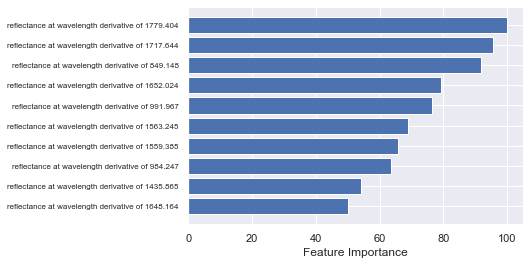

In [52]:
avg_feature_importance = 0

for s in range(n_splits):
    feature_importance = abs(clfs[s].coef_[0])
    avg_feature_importance += feature_importance
    
avg_feature_importance /= n_splits

avg_feature_importance = 100.0 * (avg_feature_importance / avg_feature_importance.max())
sorted_idx = np.argsort(avg_feature_importance)

n_most_important_features = 10

pos = np.arange(n_most_important_features) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
avg_feature_importance = avg_feature_importance[sorted_idx]

featax.barh(pos, avg_feature_importance[-n_most_important_features:], align='center')
featax.set_yticks(pos)
sorted_col_names = np.array(scaled_df_features_inc_dot.filter(regex='(ref|\.)').columns)[sorted_idx]

most_important_feature_names = sorted_col_names[-n_most_important_features:]
most_important_feature_labels = ["reflectance at wavelength {}".format(s) if re.search('(\.)', s) else s for s in most_important_feature_names]
featax.set_yticklabels(most_important_feature_labels, fontsize=8)
featax.set_xlabel('Feature Importance')
  
plt.show()

#### The importance of the features extracted using signal operators such as min, max, mean etc. is also plotted to see the importance of these features relative to the 10 most important features.

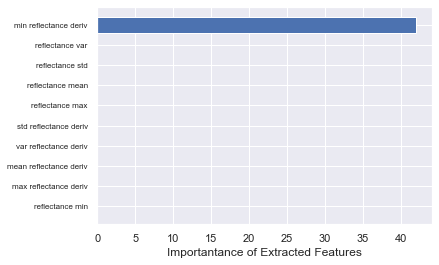

In [53]:
pos = np.arange(10) + .5
sorted_extracted_feature_names_idx = np.array([idx for idx, s in enumerate(sorted_col_names) if re.search('(ref)', s)])
sorted_extracted_feature_names = sorted_col_names[sorted_extracted_feature_names_idx]

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, avg_feature_importance[sorted_extracted_feature_names_idx], align='center')
featax.set_yticks(pos)


featax.set_yticklabels(sorted_extracted_feature_names, fontsize=8)
featax.set_xlabel('Importantance of Extracted Features')

plt.show()

### Visualize the most important features:
#### Masks are created and checked for each class of bean spectra, in order to plot the two distributions of each of the most important features.

In [54]:
scaled_df_features_inc_dot['sample'] = scaled_df_features_inc_dot['sample'].apply(pd.to_numeric)
R_mask = scaled_df_features_inc_dot['coffee'] == 'Robusta'
A_mask = scaled_df_features_inc_dot['coffee'] == 'Arabica'
R_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: coffee, dtype: bool

In [55]:
A_mask.head()

0    True
1    True
2    True
3    True
4    True
Name: coffee, dtype: bool

In [56]:
scaled_df_features_inc_dot[A_mask].head()

,sample,reflectance min,reflectance max,reflectance mean,reflectance std,reflectance var,810.548,814.408,818.268,822.128,...,derivative of 1879.764,derivative of 1883.624,derivative of 1887.484,derivative of 1891.344,derivative of 1895.204,derivative of 1899.0639999999999,derivative of 1902.924,derivative of 1906.7839999999999,derivative of 1910.644,coffee
0,1,3.449506,3.394433,3.591472,3.171943,3.729741,3.390533,3.443308,3.609417,3.656351,...,-0.742124,-0.630284,-2.564954,-3.726674,-2.436647,-1.563633,-2.033442,-1.780443,0.191339,Arabica
1,2,-0.712877,-1.607588,-1.205917,-1.595291,-1.446059,-0.837961,-0.851762,-0.863051,-0.830613,...,1.365021,1.036347,0.936884,1.273200,0.997367,0.773516,1.073424,1.442557,0.996807,Arabica
2,3,0.402050,-0.207203,0.189884,-0.216458,-0.278103,0.234046,0.267953,0.238440,0.170611,...,0.326550,0.255008,0.155952,0.329032,0.237594,-0.257516,-0.160594,-0.115129,-0.562177,Arabica
3,4,1.599128,0.610757,1.135784,0.812745,0.768244,1.226649,1.143431,1.150374,1.145576,...,-1.361166,-1.085451,-0.869149,0.327794,1.106753,-1.131038,-2.721129,-1.369803,1.544421,Arabica
4,5,2.028032,1.572291,1.824550,1.293991,1.308701,1.602872,1.620433,1.745031,1.738963,...,-2.522601,-1.237232,-0.317719,-0.210887,-1.277793,-2.120392,-2.268209,-2.067152,-0.280662,Arabica


#### The distributions of each of the 10 most important features for each class of bean spectra are then plotted. The plots show that the most of these have less overlap then the complete distributions. Note, that although some of these distributions overlap the relative importance of the features can be (and has been) proven to be useful by only using the most important features to train and evaluate the logistic regression models - when this was done, little reduction in accuracy was observed.

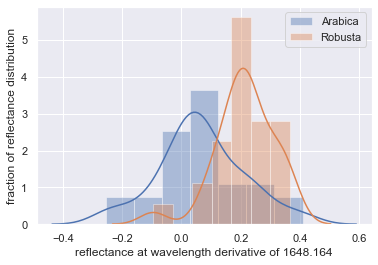

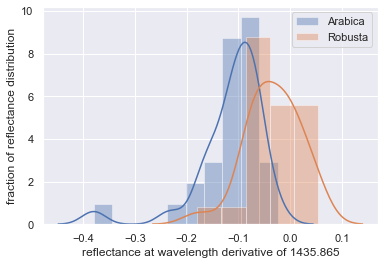

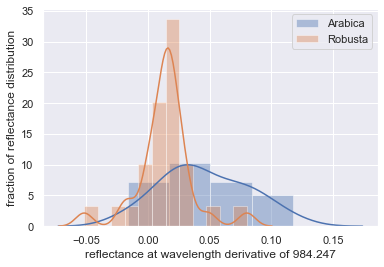

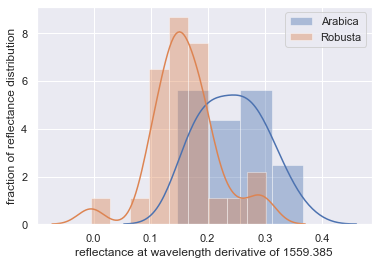

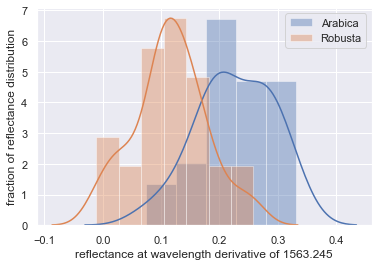

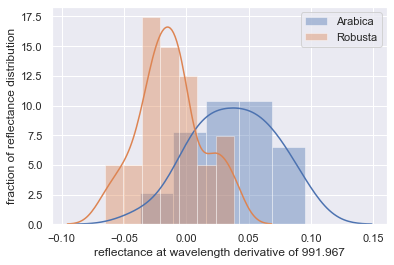

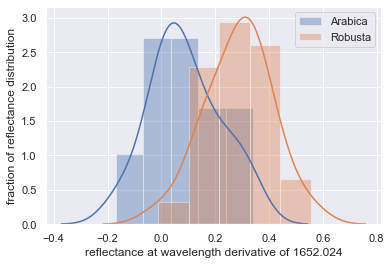

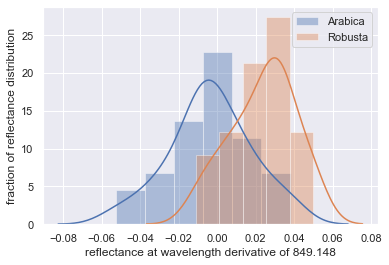

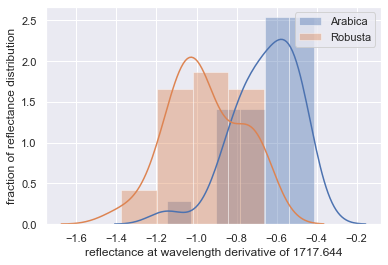

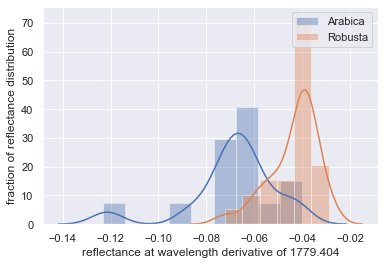

In [57]:
for idx, col in enumerate(most_important_feature_names):
    plt.figure()
    sns.distplot(df_features_inc_dot.reset_index()[A_mask][col], label='Arabica')
    sns.distplot(df_features_inc_dot.reset_index()[R_mask][col], label='Robusta')
    plt.legend(loc='upper right')
    plt.ylabel('fraction of reflectance distribution')
    plt.xlabel(most_important_feature_labels[idx]);

### Evaluate the performance of the classifiers:

#### Calculate the accuracy of the classifier using the same method as used for the previous model:
#### Interestingly, the accuracy of the new models reduce relative to the first set of models depsite the seed used, this may be due to overfitting the feature space that is very large relative to the number of samples.

In [58]:
y = np.array(y)
y_preds = np.concatenate(y_preds)

total_acc = accuracy_score(y, y_preds)
print('accuracy = ', total_acc)

accuracy =  0.9821428571428571


#### Evaluate the confusion of the classifiers by calculating and plotting the confusion matrix for the predictions:
#### The confusion matrix shows that the classifiers are very accurate, with a slight reduction in performance relative to the original set of classifiers. Again, depending on the seed used, one sample may be misclassified.

In [59]:
cm = confusion_matrix(y, y_preds)
print(cm)

[[28  1]
 [ 0 27]]


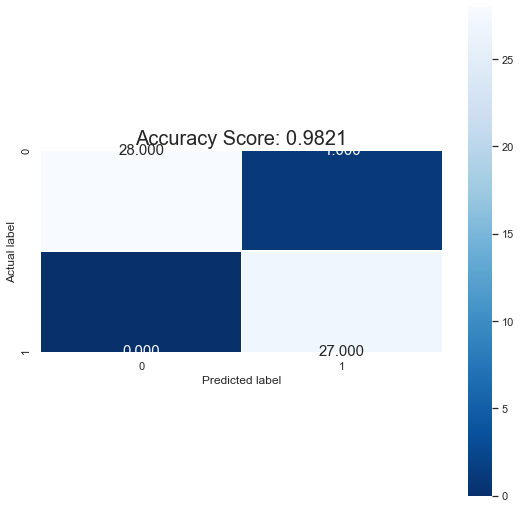

In [60]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, annot_kws={"size": 15}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0:.4g}'.format(total_acc)
plt.title(all_sample_title, size = 20);